In [122]:
import pandas as pd
import joblib
import copy
import hashlib
import json
from datetime import datetime
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import tree

#### Log

In [38]:
def time_stamp():
    return datetime.now()

In [39]:
def create_log_template():
    logger = {
        'model_name' : [],
        'model_uid' : [],
        'training_time' : [],
        'training_date' : [],
        'performance' : [],
        'f1_score_avg' : [],
        'data_configurations' : [],
    }

    return logger

In [40]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, 'r') as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, 'w') as file:
            file.write('[]')
        file.close()
        with open(log_path, 'r') as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, 'w') as file:
        json.dump(last_log, file)
        file.close()

    return last_log

#### Training

In [41]:
lgr_baseline = LogisticRegression()
dct_baseline = DecisionTreeClassifier()
rfc_baseline = RandomForestClassifier()
knn_baseline = KNeighborsClassifier()
xgb_baseline = XGBClassifier()

In [82]:
list_of_model = {
        'smote' : [
        { 'model_name': lgr_baseline.__class__.__name__, 'model_object': lgr_baseline, 'model_uid': ''},
        { 'model_name': dct_baseline.__class__.__name__, 'model_object': dct_baseline, 'model_uid': ''},
        { 'model_name': rfc_baseline.__class__.__name__, 'model_object': rfc_baseline, 'model_uid': ''},
        { 'model_name': knn_baseline.__class__.__name__, 'model_object': knn_baseline, 'model_uid': ''},
        { 'model_name': xgb_baseline.__class__.__name__, 'model_object': xgb_baseline, 'model_uid': ''}
        ],
    }

In [43]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + '-' + model['model_name']

        start_time = time_stamp()
        model['model_object'].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model['model_object'].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model['model_uid'] = chiper_id

        logger['model_name'].append(model_name)
        logger['model_uid'].append(chiper_id)
        logger['training_time'].append(elapsed_time)
        logger['training_date'].append(str(start_time))
        logger['performance'].append(performance)
        logger['f1_score_avg'].append(performance['macro avg']['f1-score'])
        logger['data_configurations'].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [136]:
x_train = joblib.load('../data/processed/x_train.pkl')
y_train = joblib.load('../data/processed/y_train.pkl')

x_test = joblib.load('../data/processed/x_test.pkl')
y_test = joblib.load('../data/processed/y_test.pkl')

x_valid = joblib.load('../data/processed/x_valid.pkl')
y_valid = joblib.load('../data/processed/y_valid.pkl')

In [126]:
training_log, list_of_model_res = train_eval_model(
    list_of_model['smote'],
    'baseline_model',
    x_train,
    y_train,
    'smote',
    x_valid,
    y_valid,
    '../log/training_log.json'
)

  0%|          | 0/5 [00:00<?, ?it/s]/home/tanaka/ml_project_final/venv_mlproject/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 5/5 [00:03<00:00,  1.52it/s]


In [127]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(['f1_score_avg', 'training_time'], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [128]:
training_res = training_log_to_df(training_log)
training_res

100%|██████████| 2/2 [00:00<00:00, 794.07it/s]


,model_name,model_uid,training_time,training_date,performance,f1_score_avg,data_configurations
0,baseline_model-KNeighborsClassifier,63658339b6ac45ebadda3bdd8a52e303,0.047785,2022-11-26 13:22:42.803686,"{'0': {'precision': 0.9544321822712709, 'recal...",0.983530,smote
1,baseline_model-DecisionTreeClassifier,aee7b2ba7522351edde0afd2c87b6165,0.117268,2022-11-26 13:22:40.644870,"{'0': {'precision': 0.9545779685264664, 'recal...",0.982089,smote
2,baseline_model-XGBClassifier,c543e3c27d3064c1f25c74f74be98470,0.524701,2022-11-26 13:22:43.038705,"{'0': {'precision': 0.9370409233997902, 'recal...",0.976705,smote
3,baseline_model-RandomForestClassifier,08485f1bcb61439ee714183f70104081,1.967675,2022-11-26 13:22:40.773575,"{'0': {'precision': 0.9370409233997902, 'recal...",0.976705,smote
4,baseline_model-LogisticRegression,6871e467e55331230228e25f299dd77c,0.344211,2022-11-26 13:22:40.283103,"{'0': {'precision': 0.8038768529076397, 'recal...",0.858010,smote
5,baseline_model-DecisionTreeClassifier,2dc1f56086247043dc5f04bca5658390,0.114738,2022-11-26 12:49:13.281523,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...",0.416775,smote
6,baseline_model-XGBClassifier,1479c1994e7bed7dec7281b6fb6a4f4e,0.545936,2022-11-26 12:49:15.716504,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...",0.416775,smote
7,baseline_model-RandomForestClassifier,f53f9d37f54a29dca5f3007a60f9c3d9,2.046423,2022-11-26 12:49:13.410972,"{'0': {'precision': 0.0, 'recall': 0.0, 'f1-sc...",0.416775,smote
8,baseline_model-KNeighborsClassifier,e762421930d4ae5dd652f717f00f616e,0.034666,2022-11-26 12:49:15.497212,"{'0': {'precision': 0.28539493293591656, 'reca...",0.222029,smote
9,baseline_model-LogisticRegression,5d11e5f93a6c833ab8bfb5223448fa86,0.285711,2022-11-26 12:49:12.982046,"{'0': {'precision': 0.2636084284460053, 'recal...",0.204109,smote


In [129]:
training_res.loc[0]

model_name                           baseline_model-KNeighborsClassifier
model_uid                               63658339b6ac45ebadda3bdd8a52e303
training_time                                                   0.047785
training_date                                 2022-11-26 13:22:42.803686
performance            {'0': {'precision': 0.9544321822712709, 'recal...
f1_score_avg                                                     0.98353
data_configurations                                                smote
Name: 0, dtype: object

#### Training dg model terbaik

In [130]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

DecisionTreeClassifier()

In [131]:
x_train

,Temperature,Humidity,TVOC,eCO2,Raw_H2,Raw_Ethanol,Pressure,PM1.0
0,27.120,47.37,1228,405,12909,19428,938.728,1.66
40392,26.990,47.68,1329,402,12971,19394,938.749,1.73
40379,18.050,52.88,97,400,13192,20078,939.665,1.06
40380,26.200,51.57,1270,400,12971,19408,938.725,1.76
40381,28.430,42.97,152,431,12774,20562,937.356,1.96
...,...,...,...,...,...,...,...,...
2003,8.687,46.95,48,411,12797,20714,937.534,2.15
774,26.800,48.28,1310,400,12977,19405,938.709,1.76
18944,12.596,53.76,1115,400,12898,19452,938.748,1.79
21139,20.920,51.16,350,400,13069,19916,939.268,0.44


[Text(0.6459703947368421, 0.9642857142857143, 'TVOC <= 217.5\ngini = 0.496\nsamples = 45207\nvalue = [24522, 20685]'),
 Text(0.46792763157894735, 0.8928571428571429, 'Raw_H2 <= 13143.5\ngini = 0.231\nsamples = 27798\nvalue = [24087, 3711]'),
 Text(0.19078947368421054, 0.8214285714285714, 'TVOC <= 209.5\ngini = 0.007\nsamples = 18800\nvalue = [18733, 67]'),
 Text(0.125, 0.75, 'Raw_H2 <= 13140.5\ngini = 0.001\nsamples = 18552\nvalue = [18542, 10]'),
 Text(0.07236842105263158, 0.6785714285714286, 'eCO2 <= 453.5\ngini = 0.0\nsamples = 18334\nvalue = [18331, 3]'),
 Text(0.046052631578947366, 0.6071428571428571, 'gini = 0.0\nsamples = 18040\nvalue = [18040, 0]'),
 Text(0.09868421052631579, 0.6071428571428571, 'TVOC <= 29.5\ngini = 0.02\nsamples = 294\nvalue = [291, 3]'),
 Text(0.07236842105263158, 0.5357142857142857, 'eCO2 <= 456.5\ngini = 0.42\nsamples = 10\nvalue = [7, 3]'),
 Text(0.046052631578947366, 0.4642857142857143, 'gini = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(0.0986842105263157

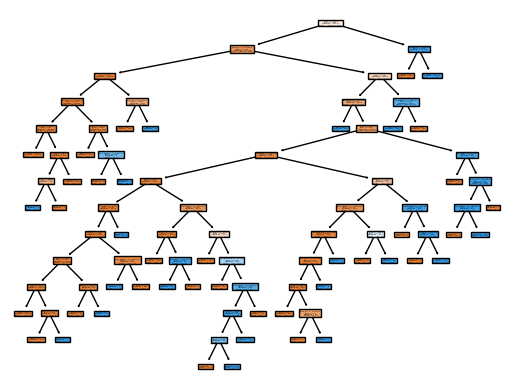

In [132]:
tree.plot_tree(dtc, filled=True, feature_names=dtc.feature_names_in_)

#### Evaluation

In [133]:
y_pred = dtc.predict(x_valid)
print(classification_report(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2681
           1       1.00      0.97      0.99      6713

    accuracy                           0.98      9394
   macro avg       0.97      0.98      0.98      9394
weighted avg       0.98      0.98      0.98      9394



In [138]:
y_pred = dtc.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2681
           1       1.00      0.98      0.99      6714

    accuracy                           0.98      9395
   macro avg       0.97      0.99      0.98      9395
weighted avg       0.98      0.98      0.98      9395



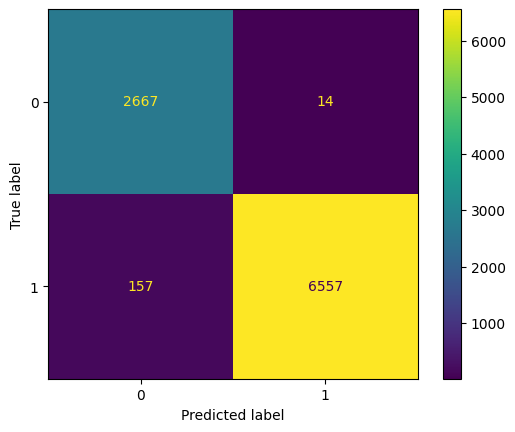

In [139]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)